# Sales Comparison by Demographic Category

for Dunnhumby: The Complete Journey

Nathaniel Poland (polandnathaniel@gmail.com)

Now that we have clean transactions, descriptive product labels, and accurate household descriptions (if only for 800 of our households...), let's see if we can distinguish our customers from one another based on their purchase behaviour. 

I hope to train a model to assign customer labels for any of our households (or even new households that we might get data for). These labels might be similar to the demographic labels which are contained in `hh_demographic.csv`, or they might be independent of those demographic categories.

## Using Demographic Labels

We have 'decision boundaries' for market segmentation already defined for us; the demographic labels such as `AGE_DESC`, `INCOME_DESC`, or `HH_SIZE_DESC` as given in the demographics table. 

Of course, as all of the households in our data are from the same sample group, their similarity based on that bias alone may be more impactful than the distinction between demographic categories within the sample.

However, it serves as a jumping-off point for further analysis; and barring the input of a subject matter expert, I'd like to take advantage of this additional information we have for some of our households.

## Examining Business Outcomes
For the purpose of creating business value for our client, we might decide to draw other decision boundaries, for example:

- based on participation in certain sales categories; for example meat, home_family, produce, junk_food, or alcohol (includes cigarettes)

- by total spend; mean basket spend; or daily spend; or any of these with relation to a sales category

- by other means, such as the RFM score or RFM Bins labels.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,6)
import seaborn as sns

import dtcj

In [3]:
merged = dtcj.load_merged()

hh_agg = dtcj.load_hh_agg(merged).reset_index() # pop household_key index into a column
hh_agg[['R','F','M']] = hh_agg[['R','F','M']].astype(int) # no categorical columns please


demo= dtcj.demo_map_categorical(pd.read_csv('data/hh_demographic.csv')) # ordered categories

clean_demo = dtcj.load_demo()

demo_list = list(demo['household_key'].unique())

# Comparing Demographic Groups using `hh_agg`

Let's examine the distribution of `RFM Bins` labels for some of these demographic labels.

In [4]:
# pare down the merged table to suit our needs
merged_demo = merged[merged['household_key'].isin(demo_list)]

print(merged_demo.shape, merged.shape)

set(demo_list) == set(merged_demo['household_key'])

(1320234, 19) (2380828, 19)


True

Always nice to drop a million rows. The `demo_list` and `merged_demo` household keys cancel out.

In [5]:
hh_demo = hh_agg[hh_agg['household_key'].isin(demo_list)]
# these are the 'customer profiles' for the households we have demographic information for. 
hh_demo.shape, hh_agg.shape

((801, 46), (2485, 46))

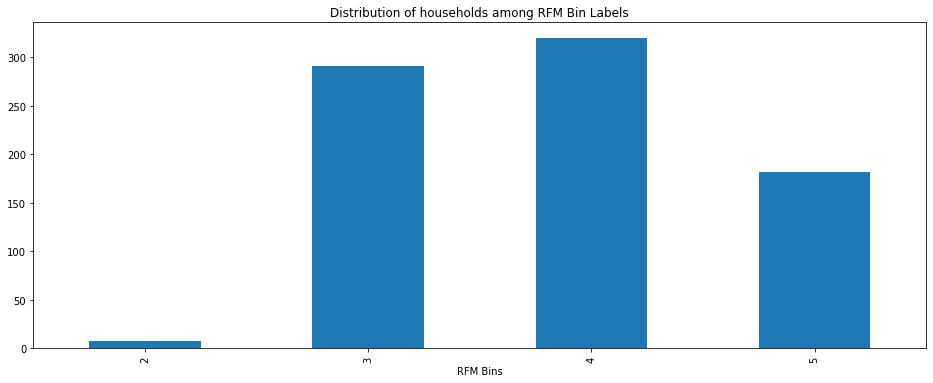

In [6]:
hh_demo['RFM Bins'].value_counts().sort_index().plot(kind='bar')
plt.title(f'Distribution of households among RFM Bin Labels')
plt.xlabel('RFM Bins')
plt.show()

We note that none of the households in our demographic information are in the lowest RFM bin, and we only have 8 households in the second-least-valuable bin.

With more information about our demographic households, we might be able to train a model to 'project' or predict demographic labels onto the other households in our data sales data by reference. Using a bagging or ensemble model jumps to mind. First, let's take a look at how our demographic labels compare, using RFM score and comparisons with the mean for columns in `hh_agg`.

# Comparing Population to Subsample

In [7]:
hh_non_demo = hh_agg[~hh_agg['household_key'].isin(demo_list)]
hh_non_demo.shape
# these are the households not listed in our demographic information

(1684, 46)

In [8]:
pd.DataFrame([hh_agg.mean(numeric_only=True), 
              hh_demo.mean(numeric_only=True), 
              hh_non_demo.mean(numeric_only=True), 
              (hh_demo.mean(numeric_only=True)-hh_non_demo.mean(numeric_only=True))], 
             index=['all households', 
                    'hh_demo', 
                    'hh_non_demo', 
                    'demo - non_demo; difference']).drop('household_key', axis=1)[['RFM', 
                                                                  'RFM Bins',
                                                                  'total_spend', 
                                                                  'avg_basket_spend', 
                                                                  'num_baskets']]

# Comparing aggregate means of demographic households and non_demographic households to the "population" (hh_agg) as a whole

,RFM,RFM Bins,total_spend,avg_basket_spend,num_baskets
all households,10.278471,3.010865,2786.773336,32.429382,94.078471
hh_demo,12.903870,3.843945,4821.232971,38.507632,147.478152
hh_non_demo,9.029691,2.614608,1819.076087,29.538243,68.678741
demo - non_demo; difference,3.874179,1.229337,3002.156885,8.969388,78.799411


We can see that the sample for which we have demographic information is significantly more engaged with our stores. 

Let's turn it into a function, such that we can break our population into subsamples and compare.

In [9]:
def compare_to_mean(population, sample, primary_id='household_key', sample_name='Subset'):
    sample_idx = list(sample[primary_id].unique())
    non_sample = population[~population[primary_id].isin(sample_idx)] #hh_non_demo?


    output = pd.DataFrame([population.mean(numeric_only=True), 
              sample.mean(numeric_only=True), 
              non_sample.mean(numeric_only=True), 
              (sample.mean(numeric_only=True)-population.mean(numeric_only=True))/population.mean(numeric_only=True)*100,
              (sample.mean(numeric_only=True)-non_sample.mean(numeric_only=True))/population.mean(numeric_only=True)*100], 
             index=[f'Population Mean', 
                    f'{sample_name} Mean', 
                   f'Non-{sample_name} Mean', 
                   f'% {sample_name} Diff to Pop. Mean',
                   f'% {sample_name} Diff to Non-{sample_name} Mean']).drop(primary_id, axis=1)
    
    return output

compare_to_mean(hh_agg, hh_demo, sample_name='Demographic Households').T
# compare all

,Population Mean,Demographic Households Mean,Non-Demographic Households Mean,% Demographic Households Diff to Pop. Mean,% Demographic Households Diff to Non-Demographic Households Mean
total_spend,2786.773336,4821.232971,1819.076087,73.004130,107.728779
total_loyalty,-509.456270,-868.402946,-338.722132,70.456818,103.969829
total_coupon,-2.899545,-6.339413,-1.263361,118.634739,175.063733
total_quantity,1257.828974,2156.305868,830.465558,71.430768,105.407042
num_baskets,94.078471,147.478152,68.678741,56.760788,83.759239
unique_products,525.352113,830.605493,380.157363,58.104531,85.742137
first_purchase,124.377465,112.141074,130.197743,-9.838109,-14.517638
last_purchase,684.029376,700.089888,676.390143,2.347927,3.464726
avg_basket_spend,32.429382,38.507632,29.538243,18.743032,27.658215
avg_item_cost,2.259002,2.242455,2.266873,-0.732518,-1.080943


We can see that the households for which have demographic information behaved differently than the households for which we do not have demographic information. Our demographic households spent more than twice as much money. Interesting to note is the total discount numbers; demographic households took advantage of discounts 175% more than non-demographic households.

## Comparing Demographic Labels 

### RFM Bins Rank

Let's take a look at the alcohol and junk food sales for our different `RFM Bins` labels, across all households:

In [10]:
# the categories we'd like to compare
targets = ['avg_basket_spend', 
          'total_spend', 
          'meat_daily_mean_spend_per_category', 
          'produce_daily_mean_spend_per_category',
          'dairy_daily_mean_spend_per_category', 
          'home_family_daily_mean_spend_per_category',
           
           'alcohol_daily_mean_spend_per_category', 
          'junk_food_daily_mean_spend_per_category',
          ]

# the labels which we'd like to examine the difference for.
hue='RFM Bins'

def plot_violins(hh_agg, hue, targets=None, plot_cols=None, fig_size=(16,6)):

    if targets==None:
        targets = ['avg_basket_spend', 
          'total_spend', 
          'meat_daily_mean_spend_per_category', 
          'produce_daily_mean_spend_per_category',
          'dairy_daily_mean_spend_per_category', 
          'home_family_daily_mean_spend_per_category',
           
           'alcohol_daily_mean_spend_per_category', 
          'junk_food_daily_mean_spend_per_category',
          ]
        
            
    total_plots= len(targets)
    if plot_cols==None:
        plot_cols=2
    
    if total_plots % plot_cols != 0:
        rows = total_plots//plot_cols+1
    else:
        rows = total_plots//plot_cols

    plt.subplots(rows, plot_cols,figsize=(fig_size))
    plt.suptitle(f'{hue}', fontsize=50)
    for idx, target in enumerate(targets):

        plt.subplot(rows, plot_cols,idx+1)

        plt.title(f'{target[:12]}', fontsize=16)
        sns.violinplot(data=hh_agg, y=target, x=hue)
        plt.ylabel(" ")

    plt.tight_layout()
    plt.show()
    

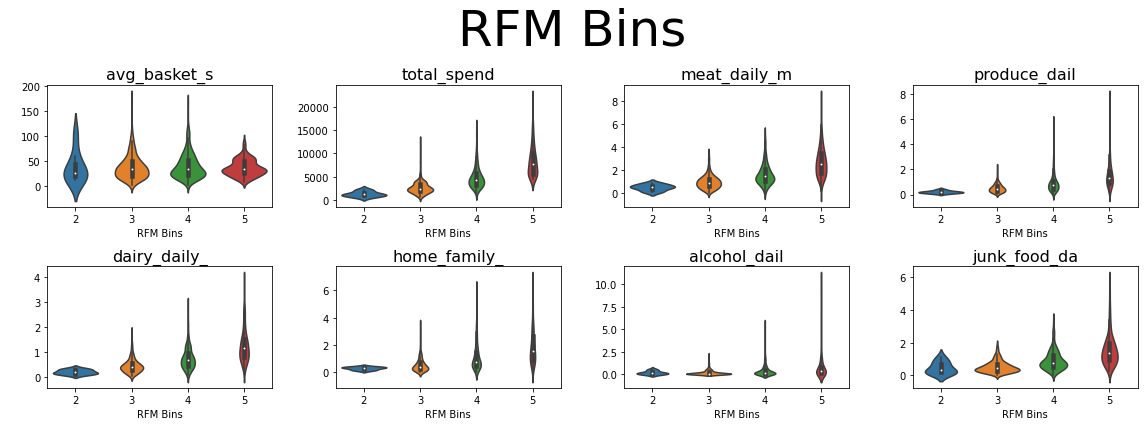

In [11]:
df = clean_demo.merge(hh_agg)

plot_violins(df, hue='RFM Bins', plot_cols=4)

Interestingly enough, our top-ranked RFM households have the highest alcohol and junk food spending by both total spend and daily average per household. Notice that the total spend values are log-transformed; this disparity between categories would be more obvious with the flat sales numbers. 

These violinplots are great at examining the 'density' of data points for each category in `hue`; in this case, `RFM Bins`. We can see that there is a much higher potential for variance for our top-ranked categories; perhaps as a byproduct of additional disposable income? Let's check.

In [12]:
df = demo.merge(hh_agg)

### Age Description

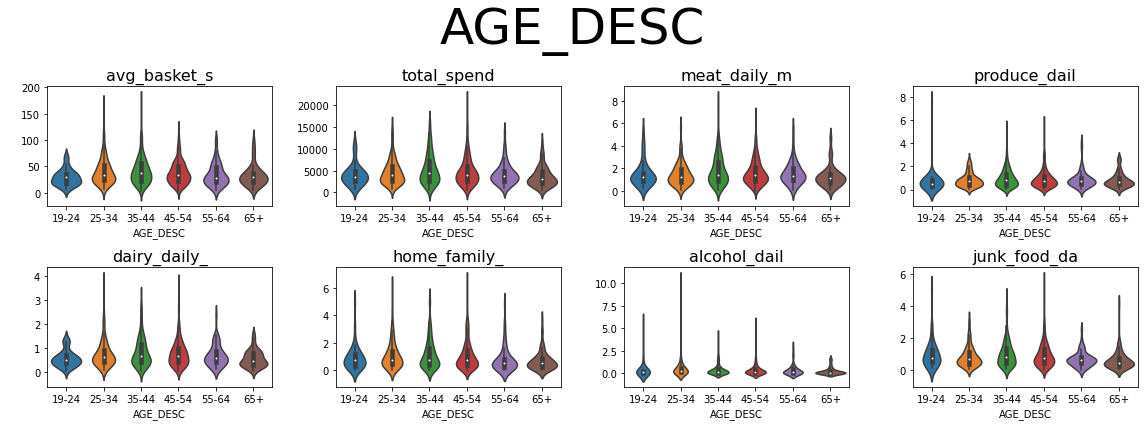

In [13]:
plot_violins(df, targets=targets, hue='AGE_DESC', plot_cols=4)

### Income Description

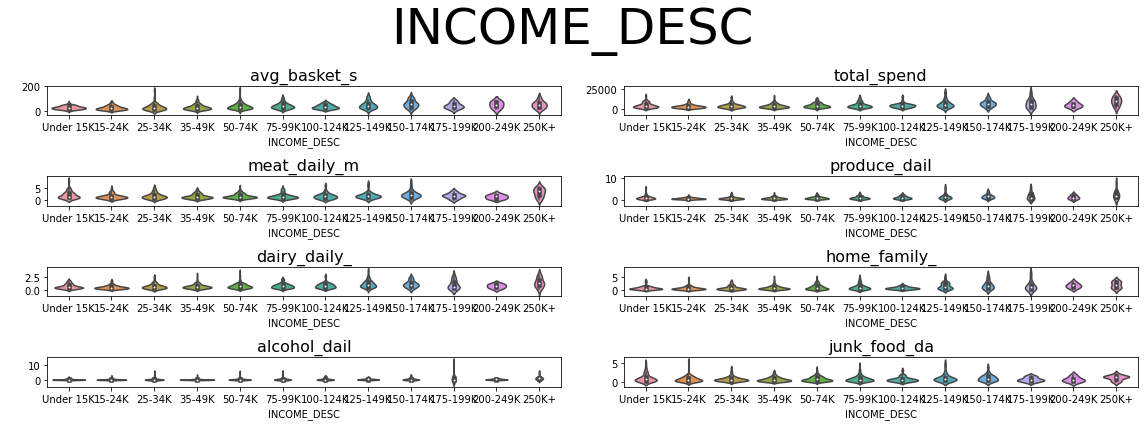

In [14]:
plot_violins(hh_demo.merge(demo, on='household_key'), targets=targets, hue='INCOME_DESC')

## Examining Sales over time across demographic categories

### Household Size Description


In [15]:
def plot_categorical_column(demo, 
                            merged,
                            mean=True,
                            resample_rule='BM',
                            sales_col='SALES_VALUE',
                            label_col='HOUSEHOLD_SIZE_DESC'):
    
    if mean==True:
        plt.title(f'Mean {sales_col} by {label_col}; over {resample_rule}')
    elif mean==False:
        plt.title(f'Sum {sales_col} by {label_col}; over {resample_rule}')

    for size in demo[label_col].unique():
        hh_ids = list(demo[demo[label_col]==size]['household_key'])
        
        if mean==True: # divide by len(hh_ids)
            plt.plot((merged[merged['household_key'].isin(hh_ids)].resample(resample_rule,convention='end', on='datetime')['SALES_VALUE'].sum()/len(hh_ids)), label=f'{size}')
        else:
            plt.plot(merged[merged['household_key'].isin(hh_ids)].resample(resample_rule,convention='end', on='datetime')['SALES_VALUE'].sum(), label=f'{size}')

    
    plt.legend()

Although messy, this chart is somewhat informative. Interesting that single and couple households seem to have more stable sales numbers, by the look of this weekly chart. If we pull it up again, this time as a monthly;

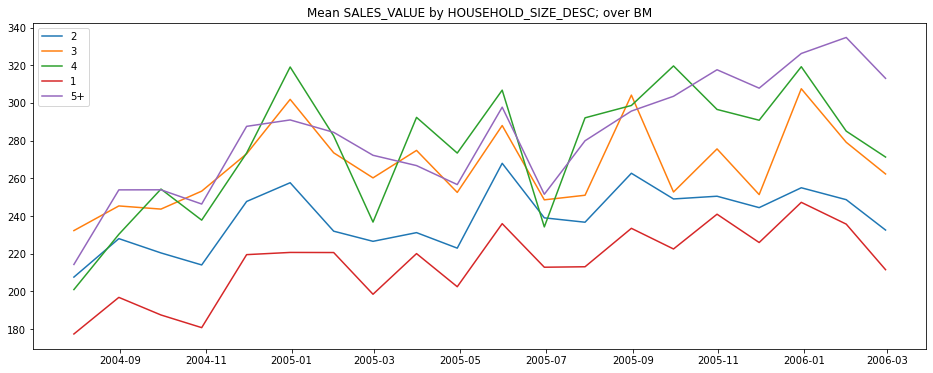

In [30]:
plt.figure(figsize=(16,6))
plot_categorical_column(demo, merged, resample_rule='BM')

- We can see that households with more members definitely seem to be purchasing more than our 1- and 2-member households.

- There is a seemingly significant downtick in revenue across family-sized categories in March and again in July 2005. 

- We have a seemingly significant increase in the average spend by households of size 5+ from that point on. However, if we look at the total sum of sales:

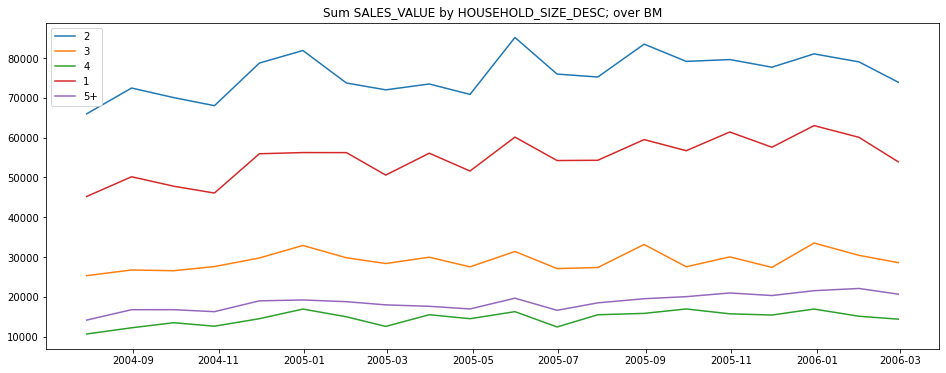

In [17]:
plt.figure(figsize=(16,6))
plot_categorical_column(demo, merged, mean=False)

We see that since the households with children are broken into three groups, the uptick isn't quite as noticeable. We'll examine the trend of the data in subsequent notebooks.

 Going back to that downtick, let's briefly glance at our advertising campaigns to see if we can identify a correlation; a campaign ending perhaps. Another theory could be that the price of a key item or series of items was increased at this time.

In [18]:
# dtcj.make_date_map(merged, 'DAY')

# Campaigns 8 and 9 ended on or near day 460; the 25th of June, 2005.

In [19]:
dtcj.load_campaign_summary(merged) ## TODO: this should load datetime values!!!


,First Day,Last Day,Duration,Listed Products,Section Label Counts,Listed Products Total Sales,Listed Products Sales Before,Listed Products Sales During,Listed Products Sales After,avg. total,avg. before,avg. during,avg. after,first,last
1,346,383,38,"[28929, 29096, 32387, 32805, 33198, 34180, 343...","{'dairy': 13496, 'produce': 7565, 'beverages':...",56764.87,21854.53,4145.12,30765.22,92.904861,88.839553,109.082105,93.511307,346.0,383.0
2,351,383,33,"[49910, 61481, 61509, 67573, 80730, 82937, 857...","{'produce': 5763, 'grocery': 2952, 'junk_food'...",47328.04,19708.03,2713.86,24906.15,77.459967,78.518048,82.238182,75.702584,351.0,383.0
3,356,412,57,"[34214, 70714, 70714, 71794, 72290, 72290, 723...","{'produce': 7634, 'misc': 6177, 'home_family':...",43048.29,18001.12,4418.59,20628.58,70.455466,70.316875,77.519123,68.761933,356.0,412.0
4,372,404,33,"[27160, 29977, 31349, 32491, 64543, 68122, 711...","{'misc': 6670, 'grain_goods': 4923, 'dairy': 1...",35052.42,16032.94,1858.32,17161.16,57.368936,58.944632,56.312727,55.718052,372.0,404.0
5,377,411,35,"[65969, 66323, 67208, 67481, 67676, 69613, 697...","{'home_family': 11490, 'misc': 204, 'grocery':...",29422.53,15473.52,1827.91,12121.1,48.154714,55.861083,52.226000,40.269435,377.0,411.0
6,393,425,33,"[13005962, 13007355, 13007356, 13007435, 13007...",{'dairy': 822},1990.16,320.94,155.72,1513.5,3.257218,1.095358,4.718788,5.273519,393.0,425.0
7,398,432,35,"[73428, 74892, 80493, 80553, 110801, 558298, 8...","{'home_family': 2290, 'drug': 608, 'meat': 358...",14204.37,6429.74,761.44,7013.19,23.247741,21.576309,21.755429,25.047107,398.0,432.0
8,412,460,49,"[1062425, 5581193, 903261, 2081690, 1096556, 9...","{'meat': 255509, 'produce': 213135, 'dairy': 1...",2488944.65,1256340.6,208783.5,1023820.55,4073.559165,4026.732692,4260.887755,4062.779960,412.0,460.0
9,435,467,33,"[27754, 28929, 29096, 29340, 30699, 31999, 341...","{'grain_goods': 12302, 'beverages': 5873, 'dai...",106644.48,54817.54,6068.44,45758.5,174.540884,163.634448,183.892121,186.769388,435.0,467.0
10,463,495,33,"[33555, 55021, 59433, 60997, 61750, 64322, 128...","{'home_family': 9918, 'misc': 206, 'grain_good...",37786.25,24387.79,1777.03,11621.43,61.843290,67.183994,53.849394,53.554977,463.0,495.0


### `AGE_DESC & INCOME_DESC`

Despite potentially having multiple members in a household, we have only a single value for `AGE_DESC` and `INCOME_DESC`; we can't be sure whether the respondent of the survey has entered their own income, or the total income of their household.

I would argue that the age description column gives us information about the breadwinners of the household (if they are similar in age) more so than it deceives us, and is therefore still a viable column for examining patterns, for example among individuals; couples; or families.

The information contained in the columns `HH_COMP_DESC`, `MARITAL_STATUS_CODE`, and `KID_CATEGORY_DESC` have inter-correlated or multi-collinear data, and might confuse any sales regression models about the feature importance of each. 

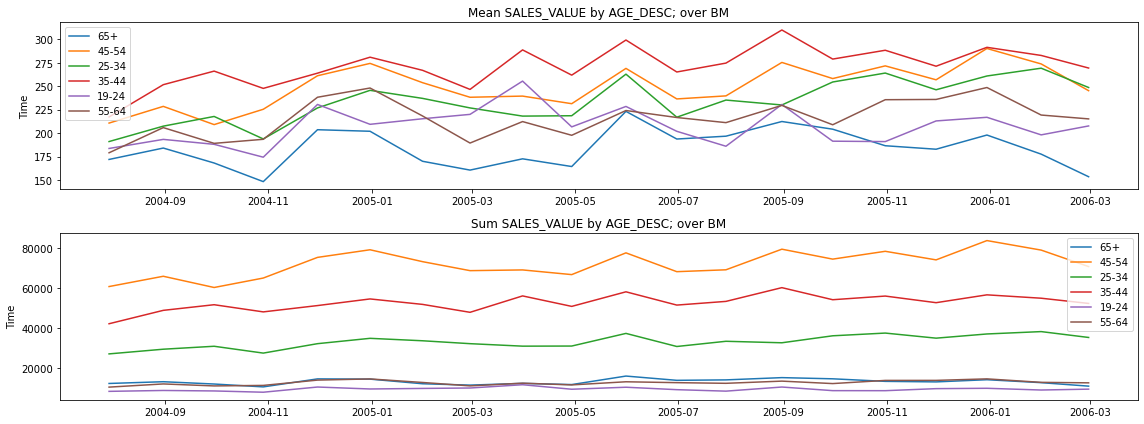

In [31]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,6))
plt.subplot(2,1,1)
plot_categorical_column(demo, merged, label_col='AGE_DESC',)
plt.ylabel('Time')
plt.subplot(2,1,2)
plot_categorical_column(demo, merged, mean=False, label_col='AGE_DESC',)
plt.ylabel('Time')
plt.tight_layout()
plt.show()

Going from 5 to 6 labels makes the plots more difficult to interpret. In the second plot we can see that households in the 34-44, as well as the 45-54 age ranges are our biggest nominal spenders. Per capita, it is the 35-44 age range that has the highest mean sum of sales. 

Slump from January through march 2005 except for youngest group; uptick across non-middle aged categories in April 2005, across all categories June 2005; and again for most categories in September 2005. We'll have to take a look again after we remove seasonality and trend from the data. 

# Sales Plots by Income Group

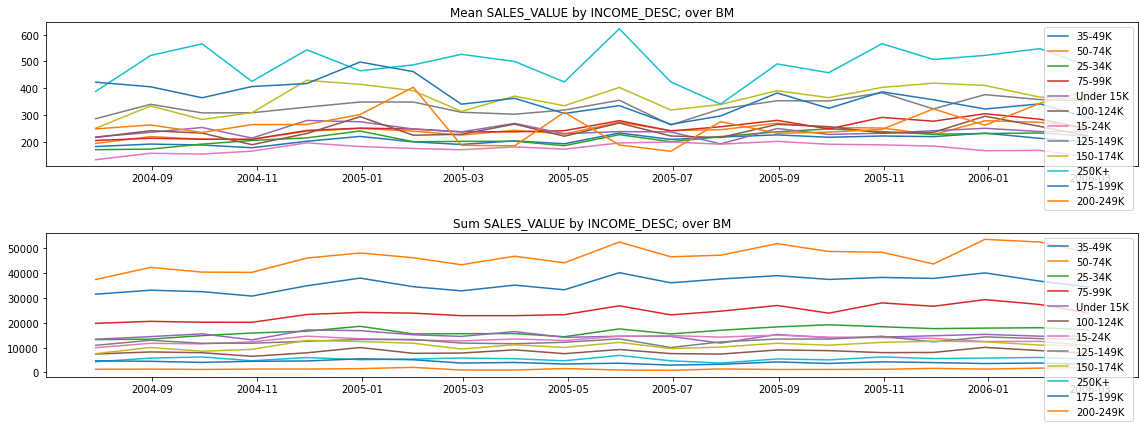

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,6))
plt.subplot(2,1,1)
plot_categorical_column(demo, merged, label_col='INCOME_DESC',)
plt.subplot(2,1,2)
plot_categorical_column(demo, merged, mean=False, label_col='INCOME_DESC',)
plt.tight_layout()
plt.show()

This column is going to need some cleaning before we can effectively visualize the groups.

In [22]:
demo['INCOME_DESC'] = demo['INCOME_DESC'].map({'Under 15K': '0-49K',
 '175-199K': '100K+',
 '35-49K': '0-49K',
 '125-149K': '100K+',
 '150-174K': '100K+',
 '15-24K': '0-49K',
 '50-74K': '50-99K',
 '250K+': '100K+',
 '200-249K': '100K+',
 '100-124K': '100K+',
 '75-99K': '50-99K',
 '25-34K': '0-49K'})

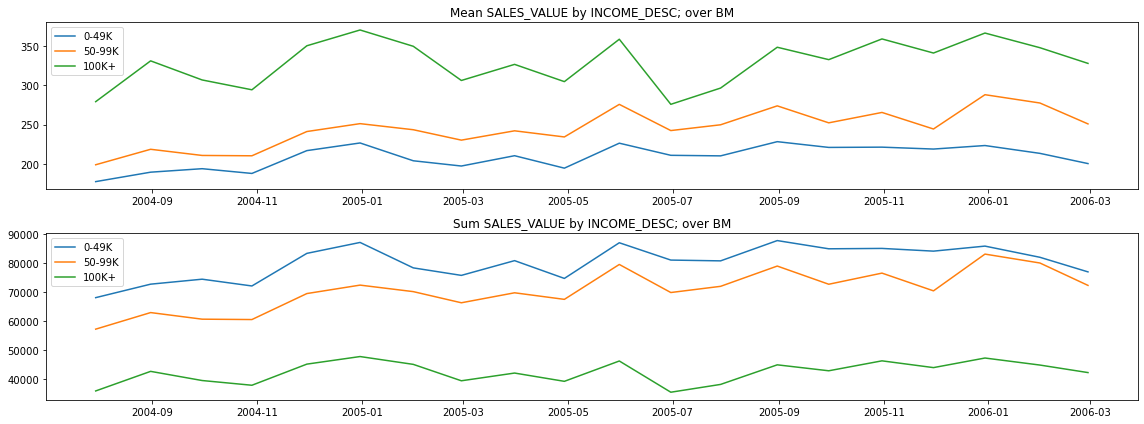

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,6))
plt.subplot(2,1,1)
plot_categorical_column(demo, merged, label_col='INCOME_DESC',)
plt.subplot(2,1,2)
plot_categorical_column(demo, merged, mean=False, label_col='INCOME_DESC',)
plt.tight_layout()
plt.show()

We see that while customers from our highest income bracket have the highest mean sum of sales; this group is actually the smallest contributor to total revenue when compared with middle and low income brackets. The lowest income bracket takes the top spot in terms of total revenue.

# DEFINING MUTUAL INFORMATION CRITERIA FOR DEMOGRAPHIC GROUPS

In [43]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

In [44]:
df = hh_demo.merge(demo, on='household_key')

In [49]:
df.columns

Index(['household_key', 'total_spend', 'total_loyalty', 'total_coupon',
       'total_quantity', 'num_baskets', 'unique_products', 'first_purchase',
       'last_purchase', 'avg_basket_spend', 'avg_item_cost',
       'alcohol_log_transformed_sales_total',
       'beverages_log_transformed_sales_total',
       'concessions_log_transformed_sales_total',
       'dairy_log_transformed_sales_total', 'drug_log_transformed_sales_total',
       'garden_log_transformed_sales_total',
       'grain_goods_log_transformed_sales_total',
       'grocery_log_transformed_sales_total',
       'home_family_log_transformed_sales_total',
       'junk_food_log_transformed_sales_total',
       'kitchen_log_transformed_sales_total',
       'meat_log_transformed_sales_total', 'misc_log_transformed_sales_total',
       'produce_log_transformed_sales_total',
       'seasonal_log_transformed_sales_total',
       'alcohol_daily_mean_spend_per_category',
       'beverages_daily_mean_spend_per_category',
       'con

In [52]:
def find_mutual_information_columns(hh_agg, demo, target):
    
    miclf = mutual_info_classif(df.drop([x for x in demo.columns if x in df.columns], axis=1), df[target])
    print(target)
    print(pd.Series(miclf, index=df.drop([x for x in demo.columns if x in df.columns], axis=1).columns).nlargest(5))
    print()

In [53]:
for target in list(demo.set_index('household_key').columns):
    find_mutual_information_columns(df, demo, target)

AGE_DESC
alcohol_log_transformed_sales_total      0.085247
M                                        0.054610
unique_products                          0.041456
alcohol_daily_mean_spend_per_category    0.035473
RFM Bins                                 0.034111
dtype: float64

MARITAL_STATUS_CODE
drug_daily_mean_spend_per_category           0.047736
total_coupon                                 0.041919
drug_log_transformed_sales_total             0.041333
grain_goods_daily_mean_spend_per_category    0.039892
grain_goods_log_transformed_sales_total      0.034302
dtype: float64

INCOME_DESC
dairy_daily_mean_spend_per_category          0.073892
grain_goods_daily_mean_spend_per_category    0.064213
avg_item_cost                                0.062719
avg_basket_spend                             0.062278
produce_log_transformed_sales_total          0.055775
dtype: float64

HOMEOWNER_DESC
dairy_daily_mean_spend_per_category          0.042913
dairy_log_transformed_sales_total            0.03513

We can see from these breakdowns that we are getting differentiation in the features used to predict distinct targets. We notice that the daily mean spend and the log transformed sales total are almost interchangeable, bringing into doubt the efficacy of providing both of these sets of values to our model. 

One notable exception is the prediction of HH_COMP_DESC; the log transformed produce sales total has the largest contribution to mutual information, where the mean spend per category is not present.

## Using Binary Targets

In [54]:
demo = dtcj.load_demo()

In [55]:
df = hh_demo.merge(demo, on='household_key')

In [56]:
def find_mutual_information_columns(hh_agg, demo, target):

    miclf = mutual_info_classif(df.drop([x for x in demo.columns if x in df.columns], axis=1), df[target])

    print(target)

    print(pd.Series(miclf, index=df.drop([x for x in demo.columns if x in df.columns], axis=1).columns).nlargest(5))
    print()

In [57]:
for target in list(demo.set_index('household_key').columns):
    find_mutual_information_columns(df, demo, target)

age_45+
alcohol_log_transformed_sales_total    0.030584
unique_products                        0.024820
drug_daily_mean_spend_per_category     0.021195
total_spend                            0.021121
total_quantity                         0.017420
dtype: float64

income_50K+
dairy_daily_mean_spend_per_category    0.059363
dairy_log_transformed_sales_total      0.057700
avg_basket_spend                       0.051324
avg_item_cost                          0.048553
misc_daily_mean_spend_per_category     0.040777
dtype: float64

single_couple_family
grain_goods_log_transformed_sales_total      0.043412
junk_food_daily_mean_spend_per_category      0.034667
RFM Bins                                     0.032598
meat_log_transformed_sales_total             0.030747
grain_goods_daily_mean_spend_per_category    0.030680
dtype: float64

has_kids
grain_goods_daily_mean_spend_per_category    0.036748
total_loyalty                                0.032092
grain_goods_log_transformed_sales_total     

We knew that age 45+ was an arbitrary division. From the results above, we know that alcohol sales can be somewhat predictive of age group. 

Grain goods spending as indicative of household description makes some sense. Meat and Recency of transactions also seems to make sense.

Has_Kids:
Total loyalty spend is noteiceable here, as well as carb-spending and home_family spend.

For single people, the distributed and binned Monetary column seems to do the most. There is also a relationship with home_family sales total.

Couples:
avg basket spend, produce, concessions, and drug spend seem to indicate a couples lifestyle. 